# Setup

In [0]:
!apt-get update
!apt-get install libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.0.7 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.0.7.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 256 kB in 2s (111 kB/s)
Reading package lists... Done
Reading package lists... Done


KeyboardInterrupt: ignored

# Setup env and import package

In [0]:
import gfootball.env as football_env
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = football_env.create_environment(env_name="academy_empty_goal", representation = 'simple115',
                   stacked=False, logdir='/tmp/football', write_goal_dumps=False, write_full_episode_dumps=False, render=False)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Class ReplayMemory: store transitions that the agent observes
+ Transition - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.

+ ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [0]:
Transition = namedtuple('Transition',
              ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN

In [0]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(115, 72)
        self.fc2 = nn.Linear(72,48)
        self.fc3 = nn.Linear(48,n_actions)   

    
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        if (x.shape[0] != BATCH_SIZE): #one-element
          x = torch.flatten(x)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.relu(self.fc3(x))
        else: #batch
          x = [F.relu(self.fc3(
              F.relu(self.fc2(
              F.relu(self.fc1(i)))))) for i in x ]
        return x

# Hyperparameters

In [0]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 100

episode_durations = []
rewardlist = []
losslist = []


# Get number of actions from football action space
n_actions = env.action_space.n
print(n_actions)
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(),lr=1e-3)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            reward = policy_net(torch.from_numpy(state).float())
            values, idx = reward.max(0)
            values, idx = values.item(), idx.item()
            '''
            print("reward:")
            print(reward)
            print("values:")
            print(values)
            print("idx:")
            print(idx)
            print("type of idx:")
            print(type(idx))
            '''
            return idx
    else:
        return random.choice(np.arange(n_actions))



19


# Plot

In [0]:

def plot():
    plt.figure(1)
    plt.clf()
    r = torch.tensor(rewardlist, dtype=torch.int)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    t = torch.tensor(losslist, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.plot(durations_t.numpy())
    plt.plot(r.numpy())
    plt.plot(t.numpy())
    plt.pause(3)  # pause a bit so that plots are updated 

def plot_durations():
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.pause(3)  # pause a bit so that plots are updated


def plot_reward():
    plt.figure(1)
    plt.clf()
    r = torch.tensor(rewardlist, dtype=torch.int)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(r.numpy())
    plt.pause(3)  # pause a bit so that plots are updated

def plot_loss():
    plt.figure(3)
    plt.clf()
    t = torch.tensor(losslist, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(t.numpy())
    plt.pause(3)  # pause a bit so that plots are updated
 

# Train

In [0]:
optimizer = optim.RMSprop(policy_net.parameters(),lr=1e-3)
def optimize_model():  # dqn
    if len(memory) < BATCH_SIZE:
        return 0
    transitions = memory.sample(BATCH_SIZE)
    # converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                              batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = (torch.tensor([s for s in batch.next_state
                          if s is not None])).view(BATCH_SIZE,-1)
    state_batch = torch.from_numpy(np.concatenate(batch.state))
    action_batch = batch.action
    reward_batch = torch.tensor(list(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_batch = state_batch.view(BATCH_SIZE,-1)
    state_action_values = torch.stack(policy_net(state_batch.float()),0)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #print(non_final_next_states.shape)

    next_state_reward = torch.stack(target_net(non_final_next_states.float()),0)

    # Compute the expected Q values and loss
    expected_state_action_values = (next_state_reward * GAMMA) + reward_batch
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    #print(loss.shape)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return float(loss)


# Start Training

Complete


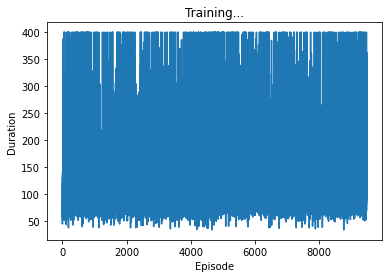

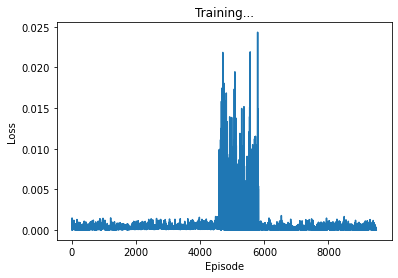

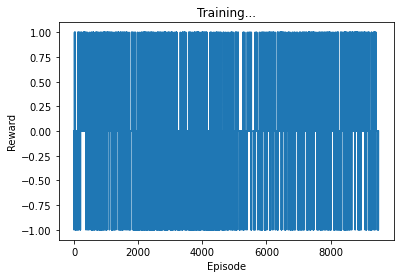

In [0]:
from tqdm.notebook import tqdm
num_episodes = 4000
tot_steps = 0
for i_episode in tqdm(range(num_episodes)):
    steps = 0
    # Initialize the environment and state
    state = env.reset()
    # print(state.shape)
    done = False
    eps_reward = 0
    tot_loss = 0.0
    while not done:
        # Select and perform an action
        action = select_action(state)
        next_st, reward, done, info = env.step(action)
        eps_reward = reward
        #if tot_steps%1000==0:
        #  print("total_step:"+str(tot_steps))
        # Store the transition in memory
        memory.push(state, action, next_st, [reward])
        # Move to the next state
        state = next_st
        tot_loss += optimize_model()
        steps += 1
        tot_steps += 1
    avg_loss = tot_loss / steps
    losslist.append(avg_loss)
    rewardlist.append(eps_reward)
    episode_durations.append(steps)
    # Update the target network, copying all weights and biases in DQN
    if (i_episode+1) % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        print("epoch#" +str(i_episode)+  ":step="     +str(steps)+
        "\treward=" +str(eps_reward) + "\tavg_loss=" +str(avg_loss))
print('Complete')
plot_durations()
plot_loss()
plot_reward()
#env.render()
#env.close()
plt.ioff()
plt.show()